Imports

In [1]:
import math
import numpy as np
import tensorflow
from tensorflow.keras.datasets import mnist, cifar10, fashion_mnist, cifar100

In [2]:
from tensorflow.keras.utils import to_categorical

Load CIFAR100 Data

In [ ]:
(training_data,training_labels),(testing_data,testing_labels) = cifar100.load_data()

169001437/169001437 [==============================] - 4s 0us/step


In [ ]:
print(training_data.shape,training_labels.shape,testing_data.shape,testing_labels.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


Use 25% of data for hyper-parameter tuning

In [ ]:
training_data = training_data[:12500,:,:]
training_labels = training_labels[:12500]
testing_data = testing_data[:2500,:,:]
testing_labels = testing_labels[:2500]
print(training_data.shape,training_labels.shape,testing_data.shape,testing_labels.shape)

(12500, 32, 32, 3) (12500, 1) (2500, 32, 32, 3) (2500, 1)


Pre-processing

In [ ]:
# Normalization - check min and max
print(np.min(training_data), np.max(training_data))
print(np.min(testing_data), np.max(testing_data))

0 255
0 255


In [ ]:
training_data = training_data.astype('float32') /255.0
testing_data = testing_data.astype('float32') / 255.0

In [ ]:
from tensorflow.keras.utils import to_categorical

nclasses = 100

# One-hot encoding for the numeric labels
training_labels = to_categorical(training_labels,num_classes=nclasses)
testing_labels = to_categorical(testing_labels,num_classes=nclasses) 

Dividing the training data to get validation set

In [ ]:
divide = int(0.1*training_data.shape[0]) # 90-10 split between training and validation sets
X_train = training_data[divide:]
X_validate = training_data[:divide]
Y_train = training_labels[divide:]
Y_validate = training_labels[:divide]
print(X_train.shape,X_validate.shape,Y_train.shape,Y_validate.shape)

(11250, 32, 32, 3) (1250, 32, 32, 3) (11250, 100) (1250, 100)


Implementation of AlexNet Architecture

In [3]:
from tensorflow.keras.layers import Dense, Conv2D, Input, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

class AlexNet:

    def __init__(self, nclasses=10) -> None:
       
        self.input_layer = Input(shape=(training_data.shape[1],training_data.shape[2],training_data.shape[3]))

        self.convolution_1_layer = Conv2D(filters=96, kernel_size=(11,11), strides=4, padding='same', activation='relu')(self.input_layer)
        self.maxpool_1_layer = MaxPool2D(pool_size=(3,3), strides=2, padding='same')(self.convolution_1_layer)
        self.norm_1_layer = BatchNormalization()(self.maxpool_1_layer)

        self.convolution_2_layer = Conv2D(filters=256, kernel_size=(5,5), strides=1, padding='same', activation='relu')(self.norm_1_layer) # wtf
        self.maxpool_2_layer = MaxPool2D(pool_size=(3,3), strides=2, padding='same')(self.convolution_2_layer)
        self.norm_2_layer = BatchNormalization()(self.maxpool_2_layer)

        self.convolution_3_layer = Conv2D(filters=384, kernel_size=(3,3), strides=1, padding='same', activation='relu')(self.norm_2_layer)
        self.convolution_4_layer = Conv2D(filters=384, kernel_size=(3,3), strides=1, padding='same', activation='relu')(self.convolution_3_layer)
        self.convolution_5_layer = Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='same', activation='relu')(self.convolution_4_layer)

        self.maxpool_3_layer = MaxPool2D(pool_size=(3,3), strides=2, padding='same')(self.convolution_5_layer)
        self.dropout_1_layer = Dropout(rate=0.5)(self.maxpool_3_layer)

        self.fc_1_layer = Flatten()(self.dropout_1_layer)
        self.fc_1_layer = Dense(units=4096, activation='relu')(self.fc_1_layer)
        self.dropout_2_layer = Dropout(rate=0.5)(self.fc_1_layer)
        self.fc_2_layer = Dense(units=4096, activation='relu')(self.dropout_2_layer)
        self.fc_3_layer = Dense(units=1000, activation='relu')(self.fc_2_layer)

        self.output_layer = Dense(units=nclasses, activation='softmax')(self.fc_3_layer)

        self.model = Model(inputs=self.input_layer, outputs=self.output_layer)

In [ ]:
model_hpt_epoch = AlexNet(nclasses=nclasses).model
model_hpt_epoch.compile(
    optimizer=optimizers.SGD(
        learning_rate=0.01,
        momentum=0.9
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)
model_hpt_epoch.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 96)          34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 96)         0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 96)         384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 256)         614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 256)        0     

In [4]:
batch_size = 32

In [ ]:
train_hist = []

In [ ]:
hist = model_hpt_epoch.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=50, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/50
352/352 [==============================] - 14s 14ms/step - loss: 4.5314 - accuracy: 0.0181 - val_loss: 4.4551 - val_accuracy: 0.0288
Epoch 2/50
352/352 [==============================] - 4s 12ms/step - loss: 4.3591 - accuracy: 0.0318 - val_loss: 4.3461 - val_accuracy: 0.0336
Epoch 3/50
352/352 [==============================] - 4s 12ms/step - loss: 4.1488 - accuracy: 0.0476 - val_loss: 4.6689 - val_accuracy: 0.0448
Epoch 4/50
352/352 [==============================] - 4s 12ms/step - loss: 4.0068 - accuracy: 0.0651 - val_loss: 3.9586 - val_accuracy: 0.0656
Epoch 5/50
352/352 [==============================] - 4s 12ms/step - loss: 3.8686 - accuracy: 0.0854 - val_loss: 3.8486 - val_accuracy: 0.0944
Epoch 6/50
352/352 [==============================] - 4s 12ms/step - loss: 3.7504 - accuracy: 0.1045 - val_loss: 3.7434 - val_accuracy: 0.1288
Epoch 7/50
352/352 [==============================] - 4s 12ms/step - loss: 3.6298 - accuracy: 0.1216 - val_loss: 3.8168 - val_accuracy: 0.113

In [5]:
import matplotlib.pyplot as plt

def showLossAccPlots2(train_hist):
    
    training_acc = []
    validate_acc = []
    train_losses = []
    validate_losses = []
    
    for th in train_hist:
        train_losses += th.history['loss']
        validate_losses += th.history['val_loss']
        training_acc += th.history['accuracy']
        validate_acc += th.history['val_accuracy']
    
    fig, (ax1, ax2) = plt.subplots(2, 1)

    epochs = range(1, len(training_acc) + 1)

    fig.suptitle('Losses and Accuracies across epochs')

    ax1.plot(epochs, train_losses, 'b', label='Training Loss')
    ax1.plot(epochs, validate_losses, 'r', label='Validation Loss')
    ax1.set_ylabel('Losses')
    ax1.legend()

    ax2.plot(epochs, training_acc, 'b', label='Train accuracy')
    ax2.plot(epochs, validate_acc, 'r', label='Validate accuracy')
    ax2.set_xlabel('epochs')
    ax2.set_ylabel('Accuracies')
    ax2.legend()

    plt.show()


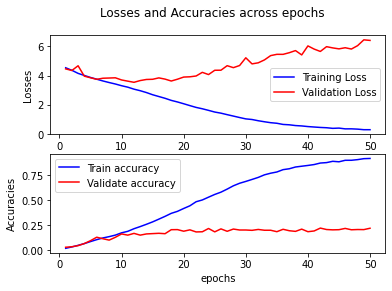

In [ ]:
showLossAccPlots2(train_hist)

As we can see, beyond 15 epcohs, validation starts to increase a lot. In fact, training accuracy continues to significantly increase, which suggests overfitting. Hence, we set the number of epochs = 15.

In [6]:
epochs = 15

In [ ]:
learning_rates = [0.001, 0.01, 0.1]

model_hpt_lr0 = AlexNet(nclasses=nclasses).model
model_hpt_lr0.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rates[0],
        momentum=0.9
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)

In [ ]:
train_hist = []
hist = model_hpt_lr0.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/15
352/352 [==============================] - 5s 13ms/step - loss: 4.6047 - accuracy: 0.0110 - val_loss: 4.6037 - val_accuracy: 0.0112
Epoch 2/15
352/352 [==============================] - 5s 13ms/step - loss: 4.5876 - accuracy: 0.0129 - val_loss: 4.5730 - val_accuracy: 0.0128
Epoch 3/15
352/352 [==============================] - 4s 12ms/step - loss: 4.5588 - accuracy: 0.0135 - val_loss: 4.5498 - val_accuracy: 0.0168
Epoch 4/15
352/352 [==============================] - 4s 12ms/step - loss: 4.5310 - accuracy: 0.0188 - val_loss: 4.5055 - val_accuracy: 0.0344
Epoch 5/15
352/352 [==============================] - 4s 12ms/step - loss: 4.4402 - accuracy: 0.0258 - val_loss: 4.3130 - val_accuracy: 0.0256
Epoch 6/15
352/352 [==============================] - 4s 12ms/step - loss: 4.3085 - accuracy: 0.0322 - val_loss: 4.2388 - val_accuracy: 0.0344
Epoch 7/15
352/352 [==============================] - 4s 12ms/step - loss: 4.2239 - accuracy: 0.0431 - val_loss: 4.1399 - val_accuracy: 0.0520

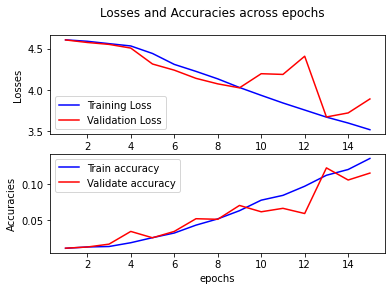

In [ ]:
showLossAccPlots2(train_hist)

In [ ]:
model_hpt_lr1 = AlexNet(nclasses=nclasses).model
model_hpt_lr1.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rates[1],
        momentum=0.9
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)

In [ ]:
train_hist = []
hist = model_hpt_lr1.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/15
352/352 [==============================] - 5s 13ms/step - loss: 4.5425 - accuracy: 0.0158 - val_loss: 4.5001 - val_accuracy: 0.0248
Epoch 2/15
352/352 [==============================] - 4s 13ms/step - loss: 4.4073 - accuracy: 0.0307 - val_loss: 4.3544 - val_accuracy: 0.0408
Epoch 3/15
352/352 [==============================] - 4s 12ms/step - loss: 4.2369 - accuracy: 0.0406 - val_loss: 4.4094 - val_accuracy: 0.0352
Epoch 4/15
352/352 [==============================] - 4s 12ms/step - loss: 4.0525 - accuracy: 0.0638 - val_loss: 4.0516 - val_accuracy: 0.0664
Epoch 5/15
352/352 [==============================] - 4s 12ms/step - loss: 3.9008 - accuracy: 0.0827 - val_loss: 4.0963 - val_accuracy: 0.0704
Epoch 6/15
352/352 [==============================] - 4s 12ms/step - loss: 3.7672 - accuracy: 0.1012 - val_loss: 4.1701 - val_accuracy: 0.0936
Epoch 7/15
352/352 [==============================] - 4s 12ms/step - loss: 3.6419 - accuracy: 0.1191 - val_loss: 3.6864 - val_accuracy: 0.1112

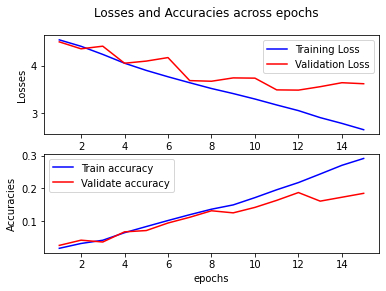

In [ ]:
showLossAccPlots2(train_hist)

In [ ]:
model_hpt_lr2 = AlexNet(nclasses=nclasses).model
model_hpt_lr2.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rates[2],
        momentum=0.9
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)

In [ ]:
train_hist = []
hist = model_hpt_lr2.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/15
352/352 [==============================] - 6s 14ms/step - loss: 4.5519 - accuracy: 0.0156 - val_loss: 4.5686 - val_accuracy: 0.0168
Epoch 2/15
352/352 [==============================] - 4s 13ms/step - loss: 4.4512 - accuracy: 0.0210 - val_loss: 4.3910 - val_accuracy: 0.0248
Epoch 3/15
352/352 [==============================] - 4s 12ms/step - loss: 4.3833 - accuracy: 0.0255 - val_loss: 4.3390 - val_accuracy: 0.0320
Epoch 4/15
352/352 [==============================] - 4s 12ms/step - loss: 4.3613 - accuracy: 0.0266 - val_loss: 4.6652 - val_accuracy: 0.0400
Epoch 5/15
352/352 [==============================] - 4s 12ms/step - loss: 4.3483 - accuracy: 0.0286 - val_loss: 4.2884 - val_accuracy: 0.0304
Epoch 6/15
352/352 [==============================] - 4s 12ms/step - loss: 4.3214 - accuracy: 0.0298 - val_loss: 4.4216 - val_accuracy: 0.0328
Epoch 7/15
352/352 [==============================] - 5s 15ms/step - loss: 4.3215 - accuracy: 0.0336 - val_loss: 4.2374 - val_accuracy: 0.0344

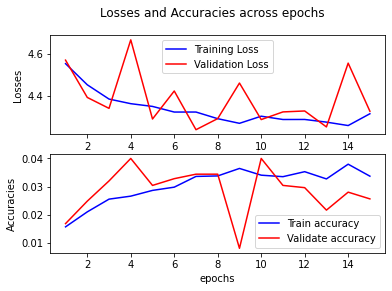

In [ ]:
showLossAccPlots2(train_hist)

We can see that lr=0.01 yields the most steady performance on the validation set, and also fits the training data comparitively better than the rest. Hence we set learning rate = 0.01

In [7]:
learning_rate = 0.01

In [ ]:
momentums = [0.9, 0.75, 0.6]

model_hpt_mt0 = AlexNet(nclasses).model
model_hpt_mt0.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentums[0]
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)

In [ ]:
train_hist = []
hist = model_hpt_mt0.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/15
352/352 [==============================] - 5s 14ms/step - loss: 4.5616 - accuracy: 0.0144 - val_loss: 4.4844 - val_accuracy: 0.0208
Epoch 2/15
352/352 [==============================] - 4s 12ms/step - loss: 4.3942 - accuracy: 0.0303 - val_loss: 4.6809 - val_accuracy: 0.0216
Epoch 3/15
352/352 [==============================] - 4s 12ms/step - loss: 4.1811 - accuracy: 0.0450 - val_loss: 4.3025 - val_accuracy: 0.0456
Epoch 4/15
352/352 [==============================] - 4s 12ms/step - loss: 4.0040 - accuracy: 0.0668 - val_loss: 4.0736 - val_accuracy: 0.0512
Epoch 5/15
352/352 [==============================] - 4s 12ms/step - loss: 3.8779 - accuracy: 0.0804 - val_loss: 4.0036 - val_accuracy: 0.0768
Epoch 6/15
352/352 [==============================] - 4s 12ms/step - loss: 3.7616 - accuracy: 0.0998 - val_loss: 3.7997 - val_accuracy: 0.0976
Epoch 7/15
352/352 [==============================] - 4s 12ms/step - loss: 3.6297 - accuracy: 0.1204 - val_loss: 3.6844 - val_accuracy: 0.1144

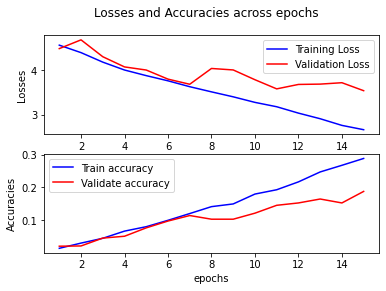

In [ ]:
showLossAccPlots2(train_hist)

In [ ]:
model_hpt_mt1 = AlexNet(nclasses).model
model_hpt_mt1.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentums[1]
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)

In [ ]:
train_hist = []
hist = model_hpt_mt1.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/15
352/352 [==============================] - 5s 13ms/step - loss: 4.5789 - accuracy: 0.0144 - val_loss: 4.5623 - val_accuracy: 0.0296
Epoch 2/15
352/352 [==============================] - 4s 12ms/step - loss: 4.3717 - accuracy: 0.0294 - val_loss: 4.1996 - val_accuracy: 0.0448
Epoch 3/15
352/352 [==============================] - 5s 14ms/step - loss: 4.1879 - accuracy: 0.0418 - val_loss: 4.3302 - val_accuracy: 0.0352
Epoch 4/15
352/352 [==============================] - 4s 13ms/step - loss: 4.0368 - accuracy: 0.0597 - val_loss: 4.0269 - val_accuracy: 0.0656
Epoch 5/15
352/352 [==============================] - 5s 13ms/step - loss: 3.9198 - accuracy: 0.0733 - val_loss: 4.2097 - val_accuracy: 0.0664
Epoch 6/15
352/352 [==============================] - 4s 12ms/step - loss: 3.8011 - accuracy: 0.0905 - val_loss: 4.0627 - val_accuracy: 0.0784
Epoch 7/15
352/352 [==============================] - 4s 12ms/step - loss: 3.6927 - accuracy: 0.1115 - val_loss: 3.9656 - val_accuracy: 0.1024

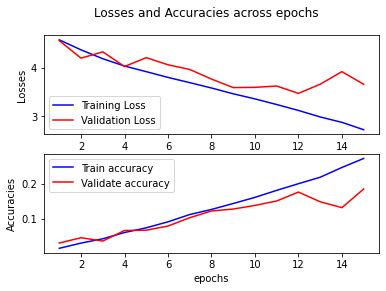

In [ ]:
showLossAccPlots2(train_hist)

In [ ]:
model_hpt_mt2 = AlexNet(nclasses).model
model_hpt_mt2.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentums[2]
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)

In [ ]:
train_hist = []
hist = model_hpt_mt2.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/15
352/352 [==============================] - 5s 14ms/step - loss: 4.5952 - accuracy: 0.0139 - val_loss: 4.5761 - val_accuracy: 0.0184
Epoch 2/15
352/352 [==============================] - 4s 12ms/step - loss: 4.4570 - accuracy: 0.0240 - val_loss: 4.4324 - val_accuracy: 0.0280
Epoch 3/15
352/352 [==============================] - 4s 12ms/step - loss: 4.2711 - accuracy: 0.0394 - val_loss: 4.1644 - val_accuracy: 0.0440
Epoch 4/15
352/352 [==============================] - 4s 12ms/step - loss: 4.1143 - accuracy: 0.0503 - val_loss: 4.4865 - val_accuracy: 0.0344
Epoch 5/15
352/352 [==============================] - 4s 12ms/step - loss: 3.9995 - accuracy: 0.0660 - val_loss: 3.9517 - val_accuracy: 0.0792
Epoch 6/15
352/352 [==============================] - 4s 12ms/step - loss: 3.8914 - accuracy: 0.0820 - val_loss: 3.8293 - val_accuracy: 0.0824
Epoch 7/15
352/352 [==============================] - 5s 13ms/step - loss: 3.7830 - accuracy: 0.0929 - val_loss: 3.7971 - val_accuracy: 0.0928

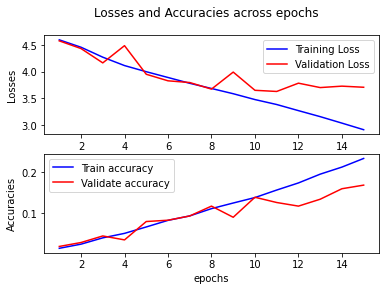

In [ ]:
showLossAccPlots2(train_hist)

Here we see that the validation accuracy is slightly higher for momentum value of 0.9 compared to 0.75 and so we will set it accordingly.

In [8]:
momentum = 0.9

MNIST Dataset

In [ ]:
(training_data,training_labels),(testing_data,testing_labels) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
training_data = training_data.reshape((training_data.shape[0],28,28,1))
training_labels = training_labels[:, np.newaxis]
testing_data = testing_data.reshape((testing_data.shape[0],28,28,1))
testing_labels = testing_labels[:, np.newaxis]
print(training_data.shape,training_labels.shape,testing_data.shape,testing_labels.shape)

(60000, 28, 28, 1) (60000, 1) (10000, 28, 28, 1) (10000, 1)


In [ ]:
# Normalization - check min and max
print(np.min(training_data), np.max(training_data))
print(np.min(testing_data), np.max(testing_data))

0 255
0 255


In [ ]:
training_data = training_data.astype('float32') /255.0
testing_data = testing_data.astype('float32') / 255.0

nclasses = len(np.unique(training_labels))

In [ ]:
# One-hot encoding for the numeric labels
training_labels = to_categorical(training_labels,num_classes=nclasses)
testing_labels = to_categorical(testing_labels,num_classes=nclasses) 

In [ ]:
divide = int(0.1*training_data.shape[0]) # 90-10 split between training and validation sets
X_train = training_data[divide:]
X_validate = training_data[:divide]
Y_train = training_labels[divide:]
Y_validate = training_labels[:divide]
print(X_train.shape,X_validate.shape,Y_train.shape,Y_validate.shape)

(54000, 28, 28, 1) (6000, 28, 28, 1) (54000, 10) (6000, 10)


In [ ]:
model_alexnet_mnist = AlexNet().model
model_alexnet_mnist.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentum
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)
model_alexnet_mnist.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_57 (Conv2D)          (None, 7, 7, 96)          11712     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 4, 4, 96)         0         
 g2D)                                                            
                                                                 
 batch_normalization_23 (Bat  (None, 4, 4, 96)         384       
 chNormalization)                                                
                                                                 
 conv2d_58 (Conv2D)          (None, 4, 4, 256)         614656    
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 2, 2, 256)        0  

In [ ]:
train_hist = []
hist = model_alexnet_mnist.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/15
1688/1688 [==============================] - 21s 12ms/step - loss: 0.2933 - accuracy: 0.9063 - val_loss: 0.1183 - val_accuracy: 0.9698
Epoch 2/15
1688/1688 [==============================] - 21s 12ms/step - loss: 0.0834 - accuracy: 0.9791 - val_loss: 0.0788 - val_accuracy: 0.9788
Epoch 3/15
1688/1688 [==============================] - 20s 12ms/step - loss: 0.0581 - accuracy: 0.9849 - val_loss: 0.0928 - val_accuracy: 0.9777
Epoch 4/15
1688/1688 [==============================] - 20s 12ms/step - loss: 0.0437 - accuracy: 0.9881 - val_loss: 0.0542 - val_accuracy: 0.9863
Epoch 5/15
1688/1688 [==============================] - 21s 13ms/step - loss: 0.0340 - accuracy: 0.9909 - val_loss: 0.0629 - val_accuracy: 0.9835
Epoch 6/15
1688/1688 [==============================] - 21s 12ms/step - loss: 0.0289 - accuracy: 0.9918 - val_loss: 0.0695 - val_accuracy: 0.9857
Epoch 7/15
1688/1688 [==============================] - 21s 12ms/step - loss: 0.0242 - accuracy: 0.9934 - val_loss: 0.0559 -

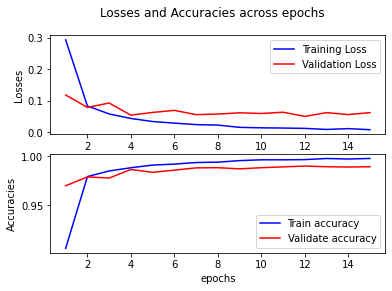

In [ ]:
showLossAccPlots2(train_hist)

In [ ]:
# Save the model
model_alexnet_mnist.save('AlexNetMnist.h5')

In [ ]:
model_alexnet_mnist.evaluate(testing_data,[testing_labels,testing_labels,testing_labels],batch_size=batch_size,verbose=1)

313/313 [==============================] - 2s 5ms/step - loss: 0.0544 - accuracy: 0.9890


[0.05435725674033165, 0.9890000224113464]

Fashion-MNIST Dataset

In [ ]:
(training_data,training_labels),(testing_data,testing_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
training_data = training_data.reshape((training_data.shape[0],28,28,1))
testing_data = testing_data.reshape((testing_data.shape[0],28,28,1))
print(training_data.shape,training_labels.shape,testing_data.shape,testing_labels.shape)

(60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


In [ ]:
# Normalization - check min and max
print(np.min(training_data), np.max(training_data))
print(np.min(testing_data), np.max(testing_data))

0 255
0 255


In [ ]:
training_data = training_data.astype('float32') /255.0
testing_data = testing_data.astype('float32') / 255.0

nclasses = len(np.unique(training_labels))

In [ ]:
# One-hot encoding for the numeric labels
training_labels = to_categorical(training_labels,num_classes=nclasses)
testing_labels = to_categorical(testing_labels,num_classes=nclasses) 

In [ ]:
divide = int(0.1*training_data.shape[0]) # 90-10 split between training and validation sets
X_train = training_data[divide:]
X_validate = training_data[:divide]
Y_train = training_labels[divide:]
Y_validate = training_labels[:divide]
print(X_train.shape,X_validate.shape,Y_train.shape,Y_validate.shape)

(54000, 28, 28, 1) (6000, 28, 28, 1) (54000, 10) (6000, 10)


In [ ]:
model_alexnet_fashion_mnist = AlexNet().model
model_alexnet_fashion_mnist.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentum
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)
model_alexnet_fashion_mnist.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_62 (Conv2D)          (None, 7, 7, 96)          11712     
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 4, 4, 96)         0         
 g2D)                                                            
                                                                 
 batch_normalization_25 (Bat  (None, 4, 4, 96)         384       
 chNormalization)                                                
                                                                 
 conv2d_63 (Conv2D)          (None, 4, 4, 256)         614656    
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 2, 2, 256)        0  

In [ ]:
train_hist = []
hist = model_alexnet_fashion_mnist.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/15
1688/1688 [==============================] - 22s 13ms/step - loss: 0.5852 - accuracy: 0.7866 - val_loss: 0.3715 - val_accuracy: 0.8672
Epoch 2/15
1688/1688 [==============================] - 21s 12ms/step - loss: 0.3722 - accuracy: 0.8664 - val_loss: 0.3444 - val_accuracy: 0.8735
Epoch 3/15
1688/1688 [==============================] - 20s 12ms/step - loss: 0.3208 - accuracy: 0.8853 - val_loss: 0.3397 - val_accuracy: 0.8815
Epoch 4/15
1688/1688 [==============================] - 21s 12ms/step - loss: 0.2905 - accuracy: 0.8953 - val_loss: 0.2871 - val_accuracy: 0.8908
Epoch 5/15
1688/1688 [==============================] - 21s 12ms/step - loss: 0.2675 - accuracy: 0.9027 - val_loss: 0.2880 - val_accuracy: 0.8938
Epoch 6/15
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2454 - accuracy: 0.9094 - val_loss: 0.2904 - val_accuracy: 0.8957
Epoch 7/15
1688/1688 [==============================] - 20s 12ms/step - loss: 0.2266 - accuracy: 0.9154 - val_loss: 0.2929 -

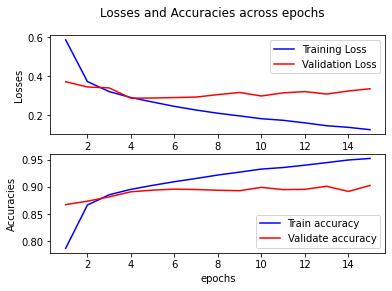

In [ ]:
showLossAccPlots2(train_hist)

In [ ]:
# Save the model
model_alexnet_fashion_mnist.save('AlexNetFashionMnist.h5')

In [ ]:
model_alexnet_fashion_mnist.evaluate(testing_data,[testing_labels,testing_labels,testing_labels],batch_size=batch_size,verbose=1)

313/313 [==============================] - 2s 5ms/step - loss: 0.3820 - accuracy: 0.8951


[0.3820170760154724, 0.8950999975204468]

CIFAR-100 Dataset

In [9]:
(training_data,training_labels),(testing_data,testing_labels) = cifar100.load_data()

169001437/169001437 [==============================] - 6s 0us/step


In [10]:
print(training_data.shape,training_labels.shape,testing_data.shape,testing_labels.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [11]:
# Normalization - check min and max
print(np.min(training_data), np.max(training_data))
print(np.min(testing_data), np.max(testing_data))

0 255
0 255


In [12]:
training_data = training_data.astype('float32') /255.0
testing_data = testing_data.astype('float32') / 255.0

nclasses = len(np.unique(training_labels))

In [13]:
# One-hot encoding for the numeric labels
training_labels = to_categorical(training_labels,num_classes=nclasses)
testing_labels = to_categorical(testing_labels,num_classes=nclasses) 

In [14]:
divide = int(0.1*training_data.shape[0]) # 90-10 split between training and validation sets
X_train = training_data[divide:]
X_validate = training_data[:divide]
Y_train = training_labels[divide:]
Y_validate = training_labels[:divide]
print(X_train.shape,X_validate.shape,Y_train.shape,Y_validate.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (45000, 100) (5000, 100)


In [15]:
model_alexnet_cifar100 = AlexNet(nclasses=100).model
model_alexnet_cifar100.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentum
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)
model_alexnet_cifar100.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 96)          34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 96)         0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 96)         384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 256)         614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 256)        0     

In [16]:
train_hist = []
hist = model_alexnet_cifar100.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/15
1407/1407 [==============================] - 25s 12ms/step - loss: 4.2504 - accuracy: 0.0420 - val_loss: 3.9855 - val_accuracy: 0.0710
Epoch 2/15
1407/1407 [==============================] - 17s 12ms/step - loss: 3.7821 - accuracy: 0.1042 - val_loss: 3.6779 - val_accuracy: 0.1148
Epoch 3/15
1407/1407 [==============================] - 17s 12ms/step - loss: 3.5099 - accuracy: 0.1504 - val_loss: 3.6385 - val_accuracy: 0.1242
Epoch 4/15
1407/1407 [==============================] - 17s 12ms/step - loss: 3.3071 - accuracy: 0.1909 - val_loss: 3.4338 - val_accuracy: 0.1690
Epoch 5/15
1407/1407 [==============================] - 18s 12ms/step - loss: 3.1300 - accuracy: 0.2241 - val_loss: 3.3339 - val_accuracy: 0.2028
Epoch 6/15
1407/1407 [==============================] - 18s 13ms/step - loss: 2.9663 - accuracy: 0.2586 - val_loss: 3.0425 - val_accuracy: 0.2658
Epoch 7/15
1407/1407 [==============================] - 17s 12ms/step - loss: 2.8198 - accuracy: 0.2879 - val_loss: 3.1087 -

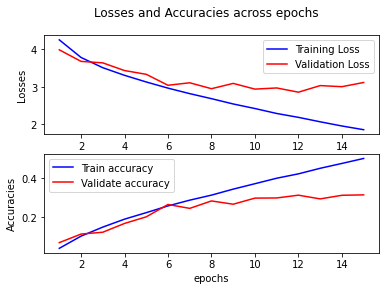

In [17]:
showLossAccPlots2(train_hist)

In [18]:
# Save the model
model_alexnet_cifar100.save('AlexNetCifar100.h5')

In [19]:
model_alexnet_cifar100.evaluate(testing_data,[testing_labels,testing_labels,testing_labels],batch_size=128,verbose=1)

79/79 [==============================] - 1s 8ms/step - loss: 3.0680 - accuracy: 0.3233


[3.0680348873138428, 0.32330000400543213]